### Introduction

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!

In [17]:
import pandas as pd

df = pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The variables are:

    1.userid - a unique number that identifies each player.
    
    2.version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
    
    3.sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.

    4.retention_1 - did the player come back and play 1 day after installing?
    
    5.retention_7 - did the player come back and play 7 days after installing?

**When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. As a sanity check, let's see if there are roughly the same number of players in each AB group.**

In [18]:
# Counting the number of players in each AB group.
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

In [19]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

In [20]:
plot_df.head(101)

sum_gamerounds
0      3994
1      5538
2      4606
3      3958
4      3629
       ... 
96      135
97      137
98      139
99      133
100     131
Name: userid, Length: 101, dtype: int64

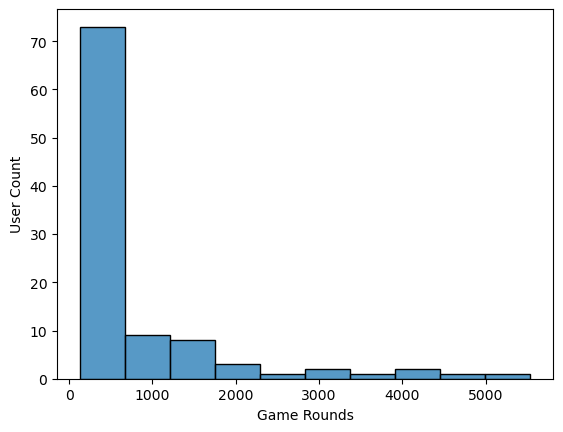

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the distribution of players that played 0 to 100 game rounds
ax = sns.histplot(plot_df.head(101),bins=10)
ax.set_xlabel('Game Rounds')
ax.set_ylabel('User Count')
plt.show()


### Overall 1-day retention

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day retention is overall.

In [22]:
# The % of users that came back the day after they installed

df['retention_1'].mean()

0.4452095044850259

### 1-day retention by AB-group
a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

In [23]:
# Calculating 1-day retention for each AB-group

df.groupby('version')['retention_1'].sum()

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

In [24]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

### Should we be confident in the diference?
It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

In [25]:
df.sample(frac=1).groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [26]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
boot_1d[:3]

[version
 gate_30    0.449314
 gate_40    0.440464
 Name: retention_1, dtype: float64,
 version
 gate_30    0.445051
 gate_40    0.442047
 Name: retention_1, dtype: float64,
 version
 gate_30    0.447024
 gate_40    0.443355
 Name: retention_1, dtype: float64]

In [27]:
boot_strap1 = pd.DataFrame(boot_1d)
boot_strap1.head()

version,gate_30,gate_40
retention_1,0.449314,0.440464
retention_1,0.445051,0.442047
retention_1,0.447024,0.443355
retention_1,0.447167,0.440628
retention_1,0.444265,0.444708


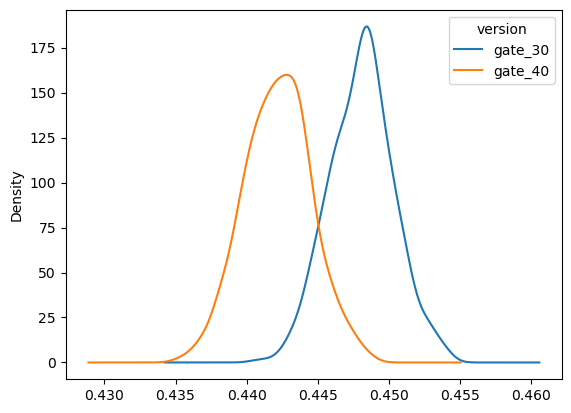

In [28]:
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_strap1.plot(kind='kde')


    These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. 
    
    Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.

In [35]:
# Adding a column with the % difference between the two AB-groups
boot_strap1['diff'] = (boot_strap1['gate_30']-boot_strap1['gate_40'])/boot_strap1['gate_40']*100
boot_strap1.head()

version,gate_30,gate_40,diff
retention_1,0.449314,0.440464,2.009252
retention_1,0.445051,0.442047,0.679709
retention_1,0.447024,0.443355,0.827562
retention_1,0.447167,0.440628,1.484098
retention_1,0.444265,0.444708,-0.099516


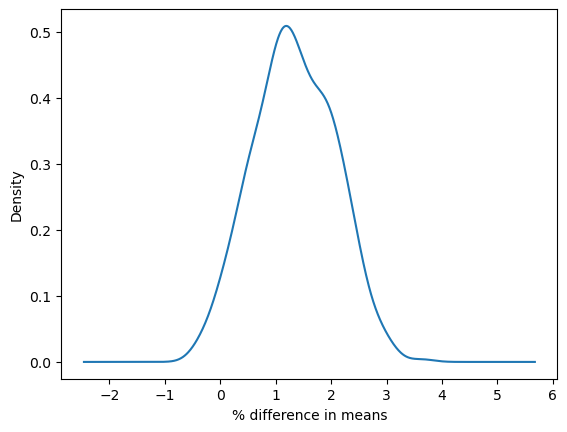

In [36]:
ax = boot_strap1['diff'].plot(kind='kde')
ax.set_xlabel('% difference in means')
plt.show()

    From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.

In [46]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30

prob = ((boot_strap1['diff']>0).sum())/len(boot_strap1['diff'])
'{:.1%}'.format(prob)

'97.4%'

### 7-day retention by AB-group
The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.



In [47]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

'100.0%'

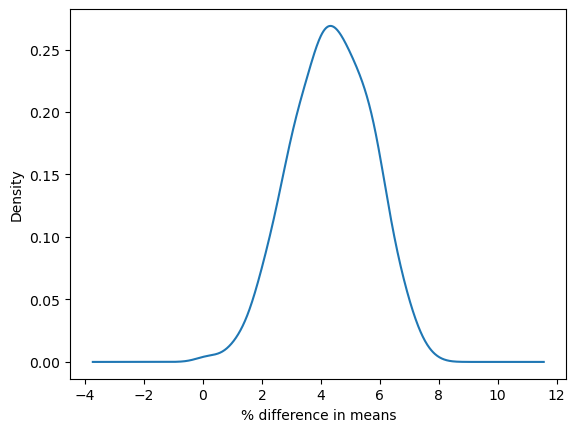

In [62]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac =1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_strap7 = pd.DataFrame(boot_7d)
boot_strap7['diff'] = (boot_strap7['gate_30']-boot_strap7['gate_40'])/boot_strap7['gate_30']*100

ax = boot_strap7['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")

prob = (boot_strap7['diff']>0).sum()/len(boot_strap7)

'{:.1%}'.format(prob)

### Conclusion

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.

